# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [235]:
%matplotlib inline

In [236]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [237]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [238]:
import warnings
warnings.filterwarnings('ignore')

In [239]:
from sklearn.decomposition import PCA

In [240]:
from sklearn.preprocessing import StandardScaler

In [241]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

In [242]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig4/'
data_path = '/data/parameter_estimation/'

### Perform some basic filtering

In [243]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [244]:
def simplify_name(name):
    return name.split('.')[0]

In [245]:
adata = sc.read(data_path + 'interferon.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['hb'] = adata.var_names.isin(['HBB', 'HBG1', 'HBG2', 'HBE1', 'HBZ', 'HBM', 'HBA2', 'HBA1', 'HBQ1'])  # annotate the group of mitochondrial genes as 'mt'

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'hb'], percent_top=None, inplace=True)

adata = adata[adata.obs.pct_counts_mt < 5, :]
adata = adata[adata.obs.pct_counts_hb < 5, :]


adata.X = adata.X.astype(np.int64)


In [246]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, copying.


... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


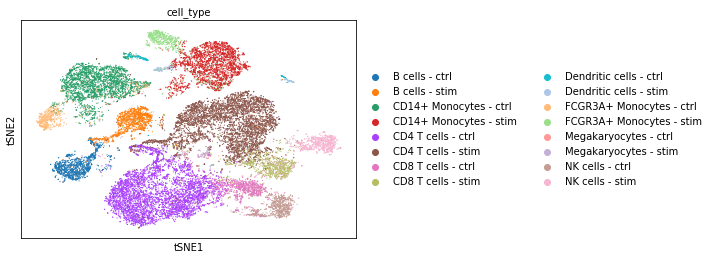

In [247]:
sc.pl.tsne(adata, color='cell_type')

In [248]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [249]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


### Perform 1D hypothesis testing

In [250]:
imp.reload(hypothesis_test)
imp.reload(scmemo)
imp.reload(bootstrap)
imp.reload(estimator)

<module 'estimator' from '/data/home/Github/scrna-parameter-estimation/scmemo/estimator.py'>

In [251]:
adata_dict = {}
for ct in cts:
    print('Processing:', ct)
    adata_dict[ct] = adata[adata.obs.cell == ct].copy()
    scmemo.create_groups(adata_dict[ct], label_columns=['stim', 'ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_dict[ct], 
        inplace=True, 
        filter_genes=True,
        residual_var=True,
        use_n_umi=False, 
        filter_mean_thresh=0.07, 
        min_perc_group=.7)
    print('Number of genes kept for {}: {}'.format(ct, adata_dict[ct].shape[1]))
    print('IFI6' in adata_dict[ct].var.index)
    scmemo.ht_1d_moments(
        adata_dict[ct], 
        formula_like='1 + stim',
        cov_column='stim', 
        num_boot=10000, 
        verbose=1,
        num_cpus=6)

Processing: CD4 T cells
Number of genes kept for CD4 T cells: 1541
True


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   10.7s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   38.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 1541 out of 1541 | elapsed:  5.2min finished


Processing: CD14+ Monocytes
Number of genes kept for CD14+ Monocytes: 1827
True


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    9.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   43.2s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 1827 out of 1827 | elapsed:  6.9min finished


Processing: FCGR3A+ Monocytes
Number of genes kept for FCGR3A+ Monocytes: 2077
True


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   21.8s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   50.2s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 2077 out of 2077 | elapsed:  4.0min finished


Processing: NK cells
Number of genes kept for NK cells: 1302
True


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   16.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   38.0s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 1302 out of 1302 | elapsed:  1.9min finished


Processing: CD8 T cells
Number of genes kept for CD8 T cells: 1241
True


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   10.8s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   25.2s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   45.7s
[Parallel(n_jobs=6)]: Done 1241 out of 1241 | elapsed:  1.2min finished


Processing: B cells
Number of genes kept for B cells: 1591
False


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   14.8s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   34.6s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 1591 out of 1591 | elapsed:  2.2min finished


In [252]:
# Save the result
for ct in cts:
    if 'mv_regressor' in adata_dict[ct].uns['scmemo']:
        adata_dict[ct].uns['scmemo']['mv_regressor'] = {}
    adata_dict[ct].write(data_path + 'result_1d/ifn_{}_7.h5ad'.format(label_converter[ct]))

... storing 'scmemo_group' as categorical
... storing 'scmemo_group' as categorical
... storing 'scmemo_group' as categorical
... storing 'scmemo_group' as categorical
... storing 'scmemo_group' as categorical
... storing 'scmemo_group' as categorical


### Read the hypothesis test result

In [158]:
adata_dict = {}
for ct in cts:
    adata_dict[ct] = sc.read(data_path + 'result_1d/ifn_{}_3.h5ad'.format(label_converter[ct]))

### Get a list of ISGF3 and IRF1 bound genes

In [ ]:
# Get the genes for ISGF3 (intersection of STAT1 and STAT2)
!~/bedtools closest \
    -a /data/chipseq/isgf3/stat1_stat2_intersect_6hr.sorted.bed \
    -b /data/chipseq/gene_tss_windows_20000.bed -d  > \
    /data/chipseq/isgf3/isgf3_genes_20000.bed

In [253]:
conversion_df = pd.read_csv('conversion.csv')[['Transcript stable ID', 'Gene name']]
conversion_df.columns = ['transcript_id', 'gene_name']

In [254]:
# isgf3 genes
isgf3_df = pd.read_csv(data_path + 'chipseq/isgf3/isgf3_genes.bed', sep='\t', header=None).iloc[:, [-2, -1]]
isgf3_df.columns=['transcript_id', 'distance']
isgf3_df = isgf3_df.query('distance == 0')
isgf3_df = isgf3_df.merge(conversion_df, on='transcript_id', how='inner')
isgf3_genes = isgf3_df['gene_name'].drop_duplicates().tolist()

In [259]:
ht_result_1d_dict = {}
for ct in cts:
    ht_result_1d_dict[ct] = scmemo.get_1d_ht_result(adata_dict[ct])
    ht_result_1d_dict[ct]['de_fdr'] = util._fdrcorrect(ht_result_1d_dict[ct]['de_pval'])
    ht_result_1d_dict[ct]['dv_fdr'] = util._fdrcorrect(ht_result_1d_dict[ct]['dv_pval'])
    ht_result_1d_dict[ct]['isgf3_binding'] = ht_result_1d_dict[ct]['gene'].apply(lambda x: x in isgf3_genes)
    ht_result_1d_dict[ct]['gene_type'] = ht_result_1d_dict[ct]['isgf3_binding'].apply(lambda x: 'ISGF3' if x else 'upreg')
    ht_result_1d_dict[ct]['ct'] = label_converter[ct]
    
    isfg3_dv = ht_result_1d_dict[ct].query('de_fdr < 0.05 & de_coef > 0 & isgf3_binding')['dv_coef']
    upreg_dv = ht_result_1d_dict[ct].query('de_fdr < 0.05 & de_coef > 0 & ~isgf3_binding')['dv_coef']
    
    print(ct, isfg3_dv.mean(), upreg_dv.mean(), stats.mannwhitneyu(isfg3_dv, upreg_dv)[1])
ht_result_1d_all = pd.concat([df for ct, df in ht_result_1d_dict.items()])

CD4 T cells -0.20281166473268256 -0.001555542062104795 0.1368507822253749
CD14+ Monocytes -0.38613360876827235 -0.08523982381810982 5.996550350344331e-05
FCGR3A+ Monocytes -0.2672074980385395 0.006127379891640124 2.8661871035455567e-05
NK cells -0.0099143064268239 0.01786621245225788 0.39212170323748063
CD8 T cells -0.13730860688729796 0.036600375172989724 0.05143755082548299
B cells -0.039810528484583364 -0.007742854669182884 0.1355396982732972


In [351]:
ht_result_1d_all.to_csv('1d_result.csv', index=False)

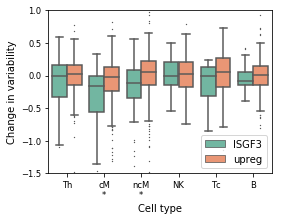

In [362]:
plt.figure(figsize=(4, 3))
sns.boxplot(
    x='ct', y='dv_coef', hue='gene_type',
    data=ht_result_1d_all.query('de_fdr < 0.05 & de_coef > 0'),
    palette=sns.color_palette('Set2'),
    fliersize=0.5)
#plt.plot([-1, 6], [0, 0], '--', lw=1, color='k')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['Th', 'cM\n*', 'ncM\n*', 'NK', 'Tc', 'B'])
plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='lower right')
plt.ylim(-1.5, 1)
plt.savefig(fig_path + 'isgf3_vs_rest.pdf', bbox_inches='tight')

### DE effect size vs DV effect size by cell type

In [291]:
def plot_de_dv(ct, result_df):
    
    de_diff = result_df['de_coef']
    dv_diff = result_df['dv_coef']
    de_fdr = result_df['de_fdr']
    dv_fdr = result_df['dv_fdr']
    
    plt.plot([0, 0], [np.nanmin(dv_diff), np.nanmax(dv_diff)], '--', lw=2, color='k')
    plt.plot([np.nanmin(de_diff), np.nanmax(de_diff)], [0, 0], '--', lw=2, color='k')
    
    de_sig = (de_fdr < 0.1)
    dv_sig = (dv_fdr < 0.1)
    both_sig = de_sig & dv_sig

    plt.scatter(de_diff, dv_diff, s=1, color='grey', zorder=-1)
#     plt.scatter(de_diff[de_sig], dv_diff[de_sig], s=1, color='b')
    plt.scatter(de_diff[both_sig], dv_diff[both_sig], s=10, color='c', zorder=10)
#     plt.scatter(de_diff[both_sig], dv_diff[both_sig], s=1, color='m')
#     plt.xlim(-0.1, .1);
#     plt.ylim(-0.5, 0.3)
        
    plt.xlabel('$\Delta$Mean')
    if ct in ['NK cells', 'CD4 T cells']:
        plt.ylabel('$\Delta$Variability')
    
    print(ct, util.robust_correlation(de_diff, dv_diff))

    plt.title(ct)
#     plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.1))
#     plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.255))

CD4 T cells SpearmanrResult(correlation=-0.009139946880865028, pvalue=0.7199615433812124)
CD14+ Monocytes SpearmanrResult(correlation=-0.15178148416226847, pvalue=7.066127225334533e-11)
FCGR3A+ Monocytes SpearmanrResult(correlation=-0.04098219700279203, pvalue=0.06946963462132918)


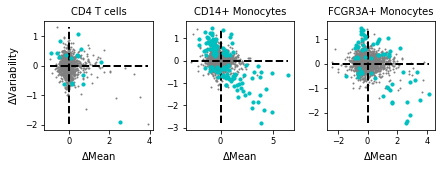

In [292]:
plt.figure(figsize=(7, 2))
plt.subplots_adjust(hspace=0.45, wspace=0.3)
for idx, ct in enumerate(cts[:3]):
    plt.subplot(1, 3, idx+1)
    plot_de_dv(ct, ht_result_1d_dict[ct])
plt.savefig(fig_path + 'de_vs_dv.png', bbox_inches='tight')
    

### Single gene example

In [293]:
def plot_bar_strip(gene, ct_to_include=None):
    
    ct_list = cts if ct_to_include is None else ct_to_include
    expr_df_list = []
    for ct in ct_list:
        if gene in adata_dict[ct].var.index:
            gene_idx = adata_dict[ct].var.index.tolist().index(gene)
            for group in adata_dict[ct].uns['scmemo']['groups']:
                expr_df_list.append((label_converter[ct], group.split('^')[0], group.split('^')[1], np.log(adata_dict[ct].uns['scmemo']['1d_moments'][group][0][gene_idx]), np.log(adata_dict[ct].uns['scmemo']['1d_moments'][group][2][gene_idx])))
    expr_df = pd.DataFrame(expr_df_list, columns=['ct','ind', 'stim', 'mean', 'variability'])

    plt.figure(figsize=(3, 3))
    plt.subplots_adjust(hspace=0.1)

    plt.subplot(2, 1, 1)
    plt.title('{} expression in response to IFN-B'.format(gene))

    ax = sns.boxplot(x='ct', y='mean', data=expr_df, hue='stim', palette=sns.color_palette('Set2'))
    ax = sns.stripplot(x='ct', y='mean', data=expr_df, hue='stim', dodge=True, palette=sns.color_palette('Set2'), edgecolor='grey', linewidth=2)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks([]); plt.xlabel('')

    plt.subplot(2, 1, 2)
    ax = sns.boxplot(x='ct', y='variability', data=expr_df, hue='stim', palette=sns.color_palette('Set2'))
    ax = sns.stripplot(x='ct', y='variability', data=expr_df, hue='stim', dodge=True, palette=sns.color_palette('Set2'), edgecolor='grey', linewidth=2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()

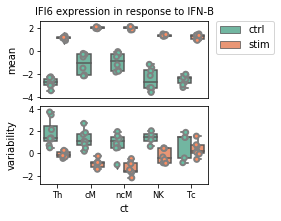

In [348]:
plot_bar_strip('IFI6', ct_to_include=None)
# plt.ylim(-1)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('IFI6'), bbox_inches='tight')

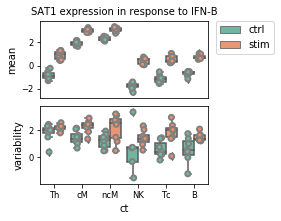

In [364]:
plot_bar_strip('SAT1', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('SAT1'), bbox_inches='tight')

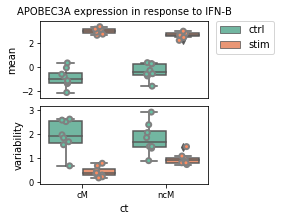

In [365]:
plot_bar_strip('APOBEC3A', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('APOBEC3A'), bbox_inches='tight')

### P-value calibrations

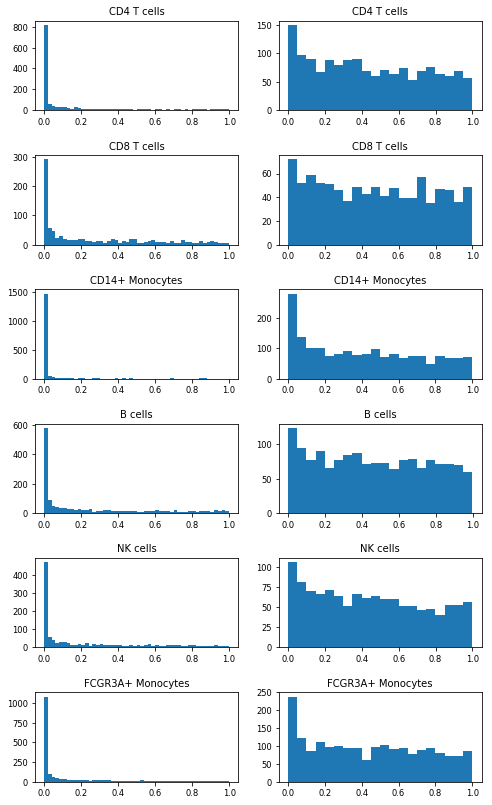

In [273]:
plt.figure(figsize=(8, 14))
plt.subplots_adjust(hspace=0.5)

for idx, ct in enumerate(['CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'FCGR3A+ Monocytes']):
    
    plt.subplot(6, 2, 2*idx+1);
    plt.hist(adata_dict[ct].uns['scmemo']['1d_ht']['mean_asl'], bins=50);
    plt.title('{}'.format(ct))
    
    plt.subplot(6, 2, 2*idx+2);
    plt.hist(adata_dict[ct].uns['scmemo']['1d_ht']['var_asl'], bins=20);
    plt.title('{}'.format(ct))
plt.savefig('de_dv_calibration.pdf', bbox_inches='tight')

### tSNE visualizations

In [274]:
ct = 'CD14+ Monocytes'

In [275]:
temp_adata = adata.copy()
temp_adata = temp_adata[temp_adata.obs.cell == ct].copy()
norm_temp_adata = temp_adata.copy()
sc.pp.normalize_total(norm_temp_adata, target_sum=1e4)
sc.pp.log1p(norm_temp_adata)

scmemo.create_groups(temp_adata, label_columns=['stim'], inplace=True)
scmemo.compute_1d_moments(
    temp_adata, 
    inplace=True, 
    filter_genes=True,
    residual_var=True,
    use_n_umi=False, 
    filter_mean_thresh=0.07, 
    min_perc_group=.7)
print('Number of genes kept for {}: {}'.format(ct, temp_adata.shape[1]))
sc.pp.normalize_total(temp_adata, target_sum=1e4)


Number of genes kept for CD14+ Monocytes: 1877


In [276]:
dv_genes = ht_result_1d_dict[ct].query('dv_fdr < 0.1').gene.tolist()
de_genes = ht_result_1d_dict[ct].query('de_fdr < 0.05').gene.tolist()

In [277]:
df = temp_adata.var.copy()
df['res_var'] = temp_adata.uns['scmemo']['1d_moments']['sg^stim'][2]
df['mean'] = temp_adata.uns['scmemo']['1d_moments']['sg^stim'][0]
df['gene'] = df.index.tolist()
df = df.merge( ht_result_1d_dict[ct], on='gene', how='left')

In [309]:
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)

             gene_ids     mt     hb  n_cells_by_counts  mean_counts  \
626   ENSG00000204525  False  False  23534              5.866129      
1528  ENSG00000108688  False  False  2148               1.198841      

      log1p_mean_counts  pct_dropout_by_counts  total_counts  \
626   1.92660            4.616382               144735.0       
1528  0.78793            91.294127              29579.0        

      log1p_total_counts    res_var  ...   gene   de_coef       de_pval  \
626   11.882667           0.427133   ...  HLA-C  0.438640  5.660027e-07   
1528  10.294854           16.452070  ...  CCL7   2.237434  3.190720e-07   

       dv_coef  dv_pval    de_fdr    dv_fdr  isgf3_binding gene_type  ct  
626  -0.470037  0.39776  0.000003  0.772670  False          upreg     cM  
1528 -0.656460  0.00048  0.000002  0.013082  False          upreg     cM  

[2 rows x 21 columns]


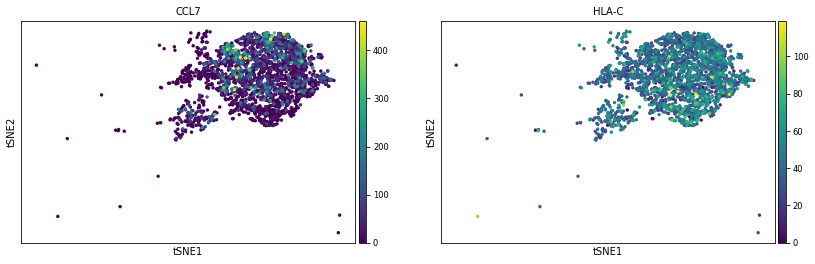

In [314]:
ct = 'CD14+ Monocytes'
gene_1, gene_2 = 'CCL7', 'HLA-C'
print(df[df.gene.isin([gene_1, gene_2])])
sc.pl.tsne(norm_adata[(norm_adata.obs.stim == 'stim') & (norm_adata.obs.cell == ct)], color=[gene_1, gene_2])

In [346]:
def variability_scatter(X, c, xlim=None, ylim=None):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.99))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=5)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim)

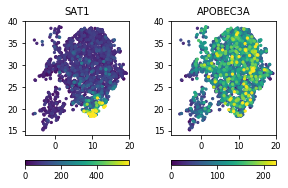

In [350]:
ct = 'CD14+ Monocytes'
gene_1, gene_2 = 'SAT1', 'APOBEC3A'
dat = norm_adata[(norm_adata.obs.stim == 'stim') & (norm_adata.obs.cell == ct)]

plt.figure(figsize=(4.5, 3))
plt.subplots_adjust(wspace=0.4)
plt.subplot(1, 2, 1)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_1].X.todense().A1, xlim=(-8, 20), ylim=(14, 40))
plt.title(gene_1)
plt.subplot(1, 2, 2)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_2].X.todense().A1, xlim=(-8, 20), ylim=(14, 40))
plt.title(gene_2)
plt.savefig(fig_path + 'SAT1_APOBEC3A_variability.pdf', bbox_inches='tight')

In [344]:
df.columns

Index(['gene_ids', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts',
       'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts',
       'log1p_total_counts', 'res_var', 'mean', 'gene', 'de_coef', 'de_pval',
       'dv_coef', 'dv_pval', 'de_fdr', 'dv_fdr', 'isgf3_binding', 'gene_type',
       'ct'],
      dtype='object')

           mean   de_coef        de_fdr   dv_coef    dv_fdr
811   20.023121  1.099953  3.214645e-06  0.814596  0.012093
1831  20.346989  3.731380  9.176641e-07 -1.527488  0.000225


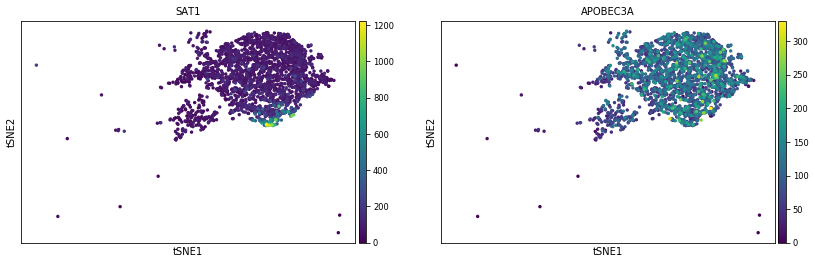

In [345]:

ct = 'CD14+ Monocytes'
gene_1, gene_2 = 'SAT1', 'APOBEC3A'
print(df[['mean', 'de_coef', 'de_fdr', 'dv_coef', 'dv_fdr']][df.gene.isin([gene_1, gene_2])])
sc.pl.tsne(norm_adata[(norm_adata.obs.stim == 'stim') & (norm_adata.obs.cell == ct)], color=[gene_1, gene_2])

            gene_ids     mt     hb  n_cells_by_counts  mean_counts  \
99   ENSG00000162645  False  False  7840               0.498521      
469  ENSG00000163734  False  False  1665               0.330929      

     log1p_mean_counts  pct_dropout_by_counts  total_counts  \
99   0.404478           68.224375              12300.0        
469  0.285877           93.251733              8165.0         

     log1p_total_counts    res_var  ...   gene   de_coef       de_pval  \
99   9.417436            0.697276   ...  GBP2   0.866642  3.944090e-06   
469  9.007734            19.588949  ...  CXCL3 -1.247853  4.603380e-07   

      dv_coef   dv_pval    de_fdr    dv_fdr  isgf3_binding gene_type  ct  
99  -0.220630  0.007400  0.000009  0.100839  False          upreg     cM  
469  0.081091  0.540546  0.000003  0.833955  False          upreg     cM  

[2 rows x 21 columns]


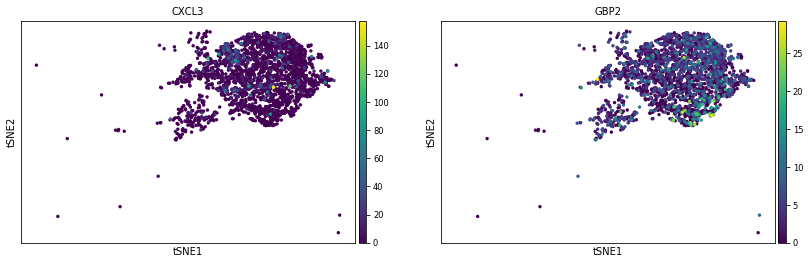

In [311]:
ct = 'CD14+ Monocytes'
gene_1, gene_2 = 'CXCL3', 'GBP2'
print(df[df.gene.isin([gene_1, gene_2])])
sc.pl.tsne(norm_adata[(norm_adata.obs.stim == 'stim') & (norm_adata.obs.cell == ct)], color=[gene_1, gene_2])

### Calibration

In [367]:
%%time

ct = 'CD14+ Monocytes'
print('Processing:', ct)
adata_test = adata[adata.obs.cell == ct].copy()
scmemo.create_groups(adata_test, label_columns=['stim', 'ind'], inplace=True)
scmemo.compute_1d_moments(
    adata_test, 
    inplace=True, 
    filter_genes=True,
    residual_var=True,
    use_n_umi=False, 
    filter_mean_thresh=0.07, 
    min_perc_group=.7)
print('Number of genes kept for {}: {}'.format(ct, adata_test.shape[1]))
# scmemo.ht_1d_moments(
#     adata_test, 
#     formula_like='1 + stim',
#     cov_column='stim', 
#     num_boot=10000, 
#     verbose=1,
#     num_cpus=6)

Processing: CD14+ Monocytes
Number of genes kept for CD14+ Monocytes: 1827
CPU times: user 214 ms, sys: 3.01 ms, total: 217 ms
Wall time: 257 ms
